In [1]:
from data import *
from models import *
from utils import *
import torch
import random

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
model_type = 'quantum' # quantum or classic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_path = "../../data/EstData.csv"
file_path = "pkpd.pkl"
model_save_path = f"./model_save_{model_type}.pt"
# model_save_path = None

# train experiments

In [3]:
prepare_dataframe(data_path, file_path)
data_loader_1d_3m = eICUDataLoader(batch_size=512, file_path=file_path, 
                             t_headings=['t'],
                             x_headings=['x'],
                             cond_headings=['c_dose', 'c_bw', 'c_comed', 'c_init'],
                             memory=3)

train_loader_1d_3m = data_loader_1d_3m.get_train_loader(shuffle=True)
val_loader_1d_3m = data_loader_1d_3m.get_val_loader()

True
True
True
True
True


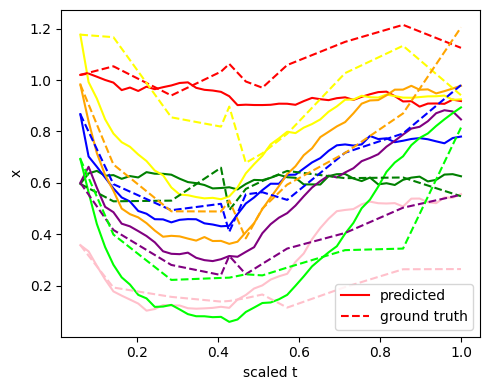

validation loss: 0.023715078830718994

CPU times: user 3.33 s, sys: 168 ms, total: 3.5 s
Wall time: 3.54 s


In [4]:
%%time
# Create the model instance
model = MLP_Cond_Memory_Module(treatment_cond=4, memory=3, 
                                     dim=1, w=32,
                                     time_varying=False, 
                                     conditional=True,
                                     lr=5e-3, 
                                     sigma=2.,
                                     loss_fn=mse_loss, 
                                     metrics=['mse_loss'], 
                                     implementation="SDE", 
                                     sde_noise=0.01, 
                                     clip=0.01,
                                     model_type = model_type
                              ).to(device)
# Load the model
try:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))
    test_model(model, False, val_loader_1d_3m, device)
# Train the model
except:
    train_model(model, False, train_loader_1d_3m, val_loader_1d_3m, num_epochs=1500, device=device, 
            eval_every=500, model_save_path = model_save_path)
    if model_save_path is not None:
        torch.save(model.state_dict(), model_save_path)
#         model.load_state_dict(torch.load(model_save_path, weights_only=True))
model.eval()  # Set the model to evaluation mode
print()

In [5]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
pytorch_total_params

450

# Tasks to solve
Your task is to develop a quantum-enhanced model to answer the following questions:

- What is the daily dose level (in whole multiples of 0.5 mg) that ensures that 90% of all subjects in a population similar to the one studied in the phase 1 trial achieve suppression of the biomarker below a clinically relevant threshold (3.3 ng/mL) throughout a 24-hour dosing interval at steady-state?
- Which weekly dose level (in whole multiples of 5 mg) has the same effect over a 168-hour dosing interval at steady-state, if the compound was dosed once-weekly?
- Suppose we change the body weight distribution of the population to be treated to 70-140 kg, how does that affect the optimal once-daily and once-weekly doses?
- Suppose we impose the restriction that concomitant medication is not allowed. How does that affect the optimal once-daily and once-weekly doses?
- How much lower would the optimal doses in the above scenarios be if we were to ensure that only 75% of all subjects achieve suppression of the biomarker below the clinically relevant threshold (3.3 ng/mL)

In [7]:
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.distributions.bernoulli import Bernoulli

sde = SDE(model.model, noise=0.1)
# Determine the distribution of the biomarker
data_df = pd.read_csv(data_path)
dv_list = []
bw_list = []
for id in range(0, 12):
    data_single = data_df[data_df["ID"] == (id+1)]
    dv_list.append(list(data_single["DV"]))
    bw_list.append([data_single["BW"].iloc[0]] * len(list(data_single["DV"])))
dv_tensor = torch.tensor(dv_list)
dv_disp = Normal(dv_tensor.mean(), dv_tensor.std())
bw_disp = Uniform(50, 100)
bw_disp_shift = Uniform(70, 140)
cm_disp = Bernoulli(0.5)

In [8]:
# The clinically relevant threshold
THRESHOLD = 3.3 / DV_rescale
# Number of steps
len_path = 50
# Number of simulations for each task
num_simulations = 100
# Number of simulations shown in each plot
num_plot = 10
# size of population
sample_shape=(1000, 1)
# Dose intervals
doses_daily = torch.arange(1., 4.5, .5) / DOSE_rescale
doses_daily_shift = torch.arange(4., 7.5, .5) / DOSE_rescale
doses_weekly = torch.arange(20., 45., 5.) / DOSE_rescale
doses_weekly_shift = torch.arange(30., 55., 5.) / DOSE_rescale

# sample initial condition
dv_init = torch.clip(dv_disp.sample(sample_shape=sample_shape) / DV_rescale, min=THRESHOLD)
dv_init = dv_init.repeat(1, 4)
dv_init += torch.randn_like(dv_init) * 0.05
# sample BW
bw = (torch.round(bw_disp.sample(sample_shape=sample_shape)) / BW_rescale).unsqueeze(1).repeat(1, len_path, 1)
bw_shift = (torch.round(bw_disp_shift.sample(sample_shape=sample_shape)) / BW_rescale).unsqueeze(1).repeat(1, len_path, 1)
# Sample COMED
cm = cm_disp.sample(sample_shape=sample_shape).unsqueeze(1).repeat(1, len_path, 1)
cm_false = torch.zeros_like(cm)

In [9]:
def dose_assigner(dose, len_path, interval=1):
    dose_period = torch.zeros((len_path, 1))
    for i in range(0, len_path, interval):
        dose_period[i] = dose.unsqueeze(0)
    return dose_period

#### Q:What is the daily dose level (in whole multiples of 0.5 mg) that ensures that 90% of all subjects in a population similar to the one studied in the phase 1 trial achieve suppression of the biomarker below a clinically relevant threshold (3.3 ng/mL) throughout a 24-hour dosing interval at steady-state?
#### Q:Which weekly dose level (in whole multiples of 5 mg) has the same effect over a 168-hour dosing interval at steady-state, if the compound was dosed once-weekly?

**Daily**

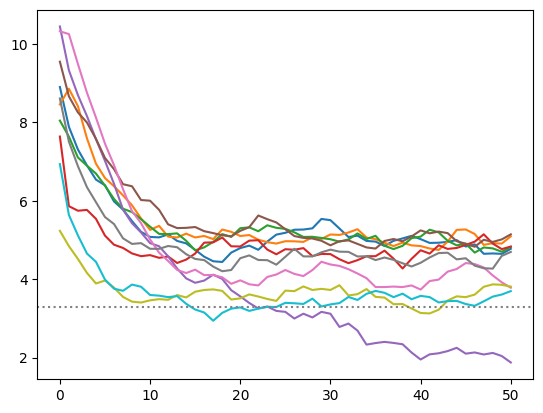

In [10]:
pred_list = []
dose = doses_daily[0]
for _ in range(num_plot):
    idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
    x0_classes = torch.cat([dose_assigner(dose, len_path, interval=1), 
                            bw[idx], cm[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
    x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
    time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
    total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
    total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
    pred_list.append(total_pred)
plt.plot(np.array(pred_list).T * DV_rescale)
plt.axhline(y=THRESHOLD * DV_rescale, ls=':', c='gray')

In [11]:
%%time
success_rate_1_daily = []
for dose in doses_daily:
    pred_list = []
    for _ in range(num_simulations):
        idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
        x0_classes = torch.cat([dose_assigner(dose, len_path, interval=1), 
                                bw[idx], cm[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
        x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
        time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
        total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
        total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
        pred_list.append(total_pred[-10:].mean())
    pred_list = np.array(pred_list)
    rate = np.sum(pred_list < THRESHOLD) / len(pred_list)
    success_rate_1_daily.append(rate)
    print(f"DOSE={dose * DV_rescale:.1f}, Success_rate={rate:.2f}")

DOSE=1.0, Success_rate=0.11
DOSE=1.5, Success_rate=0.30
DOSE=2.0, Success_rate=0.61
DOSE=2.5, Success_rate=0.72
DOSE=3.0, Success_rate=0.85
DOSE=3.5, Success_rate=0.82
DOSE=4.0, Success_rate=0.94
CPU times: user 4min 38s, sys: 58.1 ms, total: 4min 38s
Wall time: 4min 38s


**Weekly**

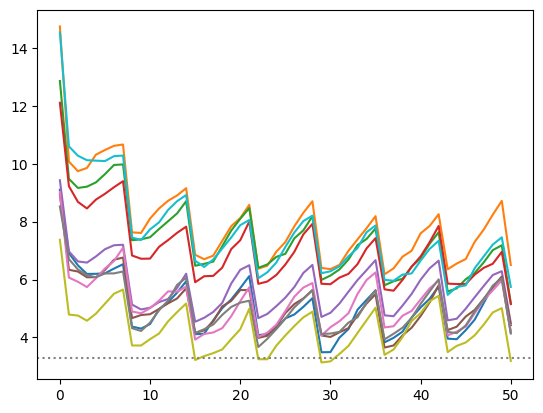

In [12]:
pred_list = []
dose = doses_weekly[0]
for _ in range(num_plot):
    idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
    x0_classes = torch.cat([dose_assigner(dose, len_path, interval=7), 
                            bw[idx], cm[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
    x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
    time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
    total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
    total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
    pred_list.append(total_pred)
plt.plot(np.array(pred_list).T * DV_rescale)
plt.axhline(y=THRESHOLD * DV_rescale, ls=':', c='gray')

In [13]:
%%time
success_rate_1_weekly = []
for dose in doses_weekly:
    pred_list = []
    for _ in range(num_simulations):
        idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
        x0_classes = torch.cat([dose_assigner(dose, len_path, interval=7), 
                                bw[idx], cm[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
        x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
        time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
        total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
        total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
        pred_list.append(total_pred[-10:].mean())
    pred_list = np.array(pred_list)
    rate = np.sum(pred_list < THRESHOLD) / len(pred_list)
    success_rate_1_weekly.append(rate)
    print(f"DOSE={dose * DV_rescale:.1f}, Success_rate={rate:.2f}")

DOSE=20.0, Success_rate=0.17
DOSE=25.0, Success_rate=0.38
DOSE=30.0, Success_rate=0.71
DOSE=35.0, Success_rate=0.95
DOSE=40.0, Success_rate=1.00
CPU times: user 3min 19s, sys: 27.9 ms, total: 3min 19s
Wall time: 3min 19s


#### Q:Suppose we change the body weight distribution of the population to be treated to 70-140 kg, how does that affect the optimal once-daily and once-weekly doses?

**Daily**

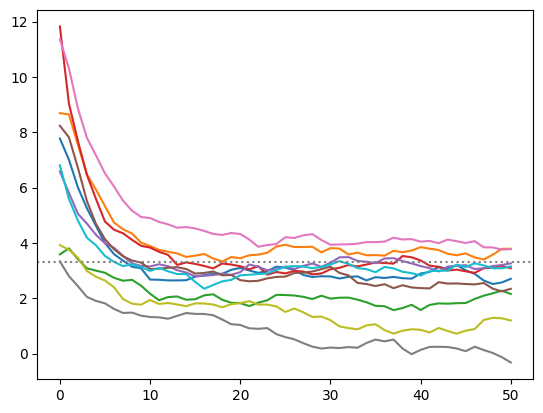

In [14]:
pred_list = []
dose = doses_daily_shift[0]
for _ in range(num_plot):
    idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
    x0_classes = torch.cat([dose_assigner(dose, len_path, interval=1), 
                            bw_shift[idx], cm[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
    x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
    time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
    total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
    total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
    pred_list.append(total_pred)
plt.plot(np.array(pred_list).T * DV_rescale)
plt.axhline(y=THRESHOLD * DV_rescale, ls=':', c='gray')

In [15]:
%%time
success_rate_2_daily = []
for dose in doses_daily_shift:
    pred_list = []
    for _ in range(num_simulations):
        idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
        x0_classes = torch.cat([dose_assigner(dose, len_path, interval=1), 
                                bw_shift[idx], cm[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
        x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
        time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
        total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
        total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
        pred_list.append(total_pred[-10:].mean())
    pred_list = np.array(pred_list)
    rate = np.sum(pred_list < THRESHOLD) / len(pred_list)
    success_rate_2_daily.append(rate)
    print(f"DOSE={dose * DV_rescale:.1f}, Success_rate={rate:.2f}")

DOSE=4.0, Success_rate=0.54
DOSE=4.5, Success_rate=0.60
DOSE=5.0, Success_rate=0.67
DOSE=5.5, Success_rate=0.67
DOSE=6.0, Success_rate=0.84
DOSE=6.5, Success_rate=0.80
DOSE=7.0, Success_rate=0.79
CPU times: user 4min 39s, sys: 28 ms, total: 4min 39s
Wall time: 4min 39s


**Weekly**

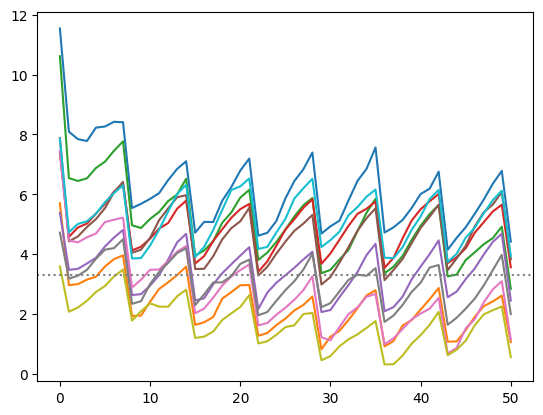

In [16]:
pred_list = []
dose = doses_weekly_shift[0]
for _ in range(num_plot):
    idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
    x0_classes = torch.cat([dose_assigner(dose, len_path, interval=7), 
                            bw_shift[idx], cm[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
    x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
    time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
    total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
    total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
    pred_list.append(total_pred)
plt.plot(np.array(pred_list).T * DV_rescale)
plt.axhline(y=THRESHOLD * DV_rescale, ls=':', c='gray')

In [17]:
%%time
success_rate_2_weekly = []
for dose in doses_weekly_shift:
    pred_list = []
    for _ in range(num_simulations):
        idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
        x0_classes = torch.cat([dose_assigner(dose, len_path, interval=7), 
                                bw_shift[idx], cm[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
        x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
        time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
        total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
        total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
        pred_list.append(total_pred[-10:].mean())
    pred_list = np.array(pred_list)
    rate = np.sum(pred_list < THRESHOLD) / len(pred_list)
    success_rate_2_weekly.append(rate)
    print(f"DOSE={dose * DV_rescale:.1f}, Success_rate={rate:.2f}")

DOSE=30.0, Success_rate=0.25
DOSE=35.0, Success_rate=0.53
DOSE=40.0, Success_rate=0.69
DOSE=45.0, Success_rate=0.86
DOSE=50.0, Success_rate=1.00
CPU times: user 3min 19s, sys: 20 ms, total: 3min 19s
Wall time: 3min 19s


#### Q:Suppose we impose the restriction that concomitant medication is not allowed. How does that affect the optimal once-daily and once-weekly doses?

**Daily**

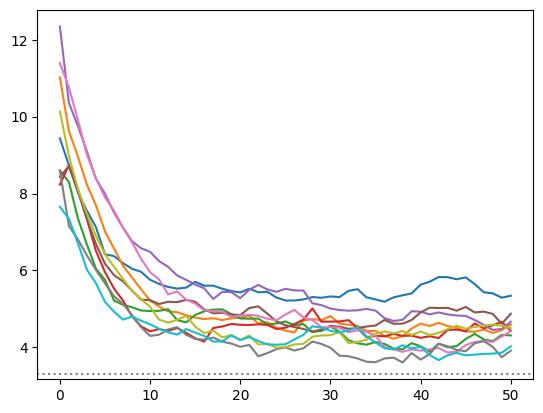

In [18]:
pred_list = []
dose = doses_daily[0]
for _ in range(num_plot):
    idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
    x0_classes = torch.cat([dose_assigner(dose, len_path, interval=1), 
                            bw[idx], cm_false[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
    x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
    time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
    total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
    total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
    pred_list.append(total_pred)
plt.plot(np.array(pred_list).T * DV_rescale)
plt.axhline(y=THRESHOLD * DV_rescale, ls=':', c='gray')

In [19]:
%%time
success_rate_3_daily = []
for dose in doses_daily:
    pred_list = []
    for _ in range(num_simulations):
        idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
        x0_classes = torch.cat([dose_assigner(dose, len_path, interval=1), 
                                bw[idx], cm_false[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
        x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
        time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
        total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
        total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
        pred_list.append(total_pred[-10:].mean())
    pred_list = np.array(pred_list)
    rate = np.sum(pred_list < THRESHOLD) / len(pred_list)
    success_rate_3_daily.append(rate)
    print(f"DOSE={dose * DV_rescale:.1f}, Success_rate={rate:.2f}")

DOSE=1.0, Success_rate=0.13
DOSE=1.5, Success_rate=0.36
DOSE=2.0, Success_rate=0.70
DOSE=2.5, Success_rate=0.75
DOSE=3.0, Success_rate=0.91
DOSE=3.5, Success_rate=0.95
DOSE=4.0, Success_rate=1.00
CPU times: user 4min 40s, sys: 40 ms, total: 4min 40s
Wall time: 4min 41s


**Weekly**

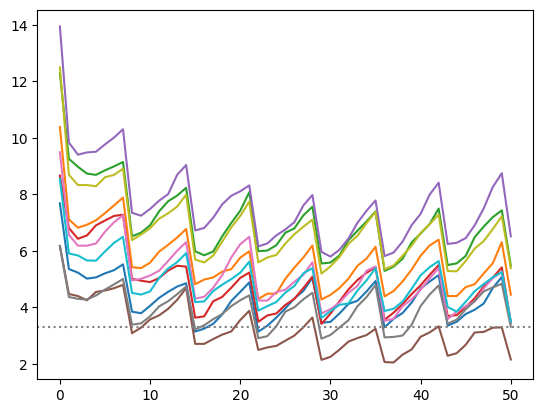

In [20]:
pred_list = []
dose = doses_weekly[0]
for _ in range(num_plot):
    idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
    x0_classes = torch.cat([dose_assigner(dose, len_path, interval=7), 
                            bw[idx], cm_false[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
    x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
    time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
    total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
    total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
    pred_list.append(total_pred)
plt.plot(np.array(pred_list).T * DV_rescale)
plt.axhline(y=THRESHOLD * DV_rescale, ls=':', c='gray')

In [21]:
%%time
success_rate_3_weekly = []
for dose in doses_weekly:
    pred_list = []
    for _ in range(num_simulations):
        idx = torch.randint(low=0, high=sample_shape[0], size=(1, ))[0]
        x0_classes = torch.cat([dose_assigner(dose, len_path, interval=7), 
                                bw[idx], cm_false[idx], dv_init[idx, :model.dim].repeat(len_path, 1)], dim=1).to(device)
        x0_values = dv_init[idx, :model.dim].unsqueeze(0).to(device)
        time_history = dv_init[idx,-(model.memory * model.dim):].to(device)
        total_pred = simulate(model, sde, x0_classes, x0_values, time_history, len_path)
        total_pred = torch.stack(total_pred).squeeze().detach().cpu().numpy()
        pred_list.append(total_pred[-10:].mean())
    pred_list = np.array(pred_list)
    rate = np.sum(pred_list < THRESHOLD) / len(pred_list)
    success_rate_3_weekly.append(rate)
    print(f"DOSE={dose * DV_rescale:.1f}, Success_rate={rate:.2f}")

DOSE=20.0, Success_rate=0.18
DOSE=25.0, Success_rate=0.35
DOSE=30.0, Success_rate=0.74
DOSE=35.0, Success_rate=0.94
DOSE=40.0, Success_rate=1.00
CPU times: user 3min 19s, sys: 28 ms, total: 3min 19s
Wall time: 3min 19s


#### Visualization

Text(0.5, 1.0, 'Weekly')

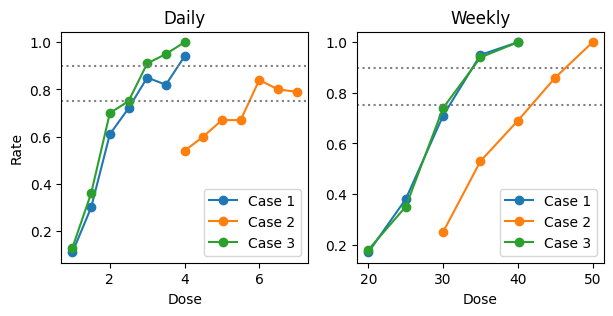

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (7, 3))
axs[0].plot(doses_daily * DV_rescale, success_rate_1_daily, marker='o', label = 'Case 1')
axs[1].plot(doses_weekly * DV_rescale, success_rate_1_weekly, marker='o', label = 'Case 1')
axs[0].plot(doses_daily_shift * DV_rescale, success_rate_2_daily, marker='o', label = 'Case 2')
axs[1].plot(doses_weekly_shift * DV_rescale, success_rate_2_weekly, marker='o', label = 'Case 2')
axs[0].plot(doses_daily * DV_rescale, success_rate_3_daily, marker='o', label = 'Case 3')
axs[1].plot(doses_weekly * DV_rescale, success_rate_3_weekly, marker='o', label = 'Case 3')
for ax in axs:
    ax.legend()
    ax.axhline(y=0.75, ls=':', c='gray')
    ax.axhline(y=0.9, ls=':', c='gray')
axs[0].set_ylabel('Rate')
axs[0].set_xlabel("Dose")
axs[0].set_title("Daily")
# axs[1].set_ylabel('Rate')
axs[1].set_xlabel("Dose")
axs[1].set_title("Weekly")